In [ ]:
# %% Importing the libraries

# python
import math
import time
import random
import os
import sys
import copy

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

# panda
import pandas as pd

# Symbol python
import sympy as sym

# PyTroch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
import torchvision.transforms as T
from torchsummary import summary

# Seaborn
import seaborn as sns

# sckitlearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
import sklearn.metrics as skm

# scipy
import scipy.stats as stats
from scipy.signal import convolve2d

# read image
from imageio import imread

# set directory
import inspect, os.path
filename = inspect.getframeinfo(inspect.currentframe()).filename
path_dir = os.path.dirname(os.path.abspath(filename))
os.chdir(path_dir) # set the working directory
cd = os.getcwd()

# SSL
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# Settings
np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 0.5  # default 0.8
plt.rcParams["figure.subplot.hspace"] = 0.25

In [ ]:
#%% Import Class & Functions

# from google.colab import drive
# drive.mount('/content/drive')

# sys.path.append('/content/drive/MyDrive/ColabNotebooks')

# # CNN Class
# import Class.CNN as CNN

# # Function
# from Function.dSplit import dSplit
# import Function.LossFunc as LF

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
#%% Import data

#%% Import dataset

# MNIST data
fname = 'sample_data/mnist_train_small.csv'
fdata = np.loadtxt(open(fname, 'rb'), delimiter=',')

# extract data and labels
labels = fdata[:, 0]
data = fdata[:, 1:]
classes = np.unique(labels)

In [ ]:
#%% data preprocessing

# **********normalize the data to [-1 1]************
dataNorm = data / np.max(data) # to [0 1]
dataNorm = 2*dataNorm - 1 # to [-1 1]

# reshape to 2D
# dataNorm = dataNorm.reshape(dataNorm.shape[0], 1, 28, 28)

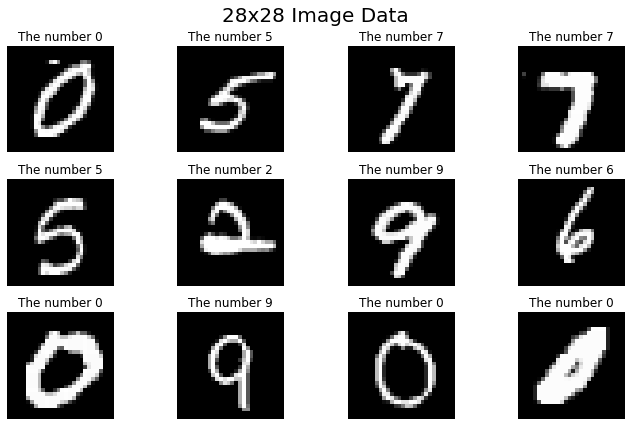

In [ ]:
#%% Data inspection

# show a few random  of 28x28 img
fig, axs = plt.subplots(3, 4, figsize=(10, 6))

# generate random number
randimg2show = np.random.randint(data.shape[0], size=len(axs.flatten()))


for i, ax in enumerate(axs.flatten()):
  
    # create the image (must be reshaped!)
    img = np.reshape(data[randimg2show[i],:], (28, 28))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    
    # title
    ax.set_title(f'The number {labels[randimg2show[i]]:.0f}')

plt.suptitle('28x28 Image Data', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, .95])
plt.show()


In [ ]:
#%% convert to tensor
data_ts = torch.tensor(dataNorm).float()


Models Classes

In [ ]:
class discriminatorNet(nn.Module):

  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(28*28, 256) # 28*28 = 784
    self.fc2 = nn.Linear(256, 256)
    self.out = nn.Linear(256, 1)

  def forward(self, x):

    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = self.out(x)
    x = torch.sigmoid(x)

    return x

In [ ]:
class generatorNet(nn.Module):

  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(64, 256)
    self.fc2 = nn.Linear(256, 256)
    self.out = nn.Linear(256, 28*28) # 28*28 = 784

  def forward(self, x):

    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = self.out(x)
    x = torch.tanh(x)

    return x

Models Instance & params

In [ ]:
# models instance
d_net = discriminatorNet().to(device)
g_net = generatorNet().to(device)

# loss function
loss_fun = nn.BCELoss()

# optimizer
d_optimizer = torch.optim.Adam(d_net.parameters(), lr=.0003)
g_optimizer = torch.optim.Adam(g_net.parameters(), lr=.0003)

# training epochs
epochs = 50000

# batch size
batch_size = 100

In [ ]:
# init vars to store results
d_loss = torch.zeros((epochs)) # for discriminator
g_loss = torch.zeros((epochs)) # for generator
d_pred_train_d = torch.zeros((epochs)) # discriminator prediction on training discriminator
d_pred_train_g = torch.zeros((epochs)) # discriminator prediction on training generator

Train model

In [ ]:
for epochi in range(epochs):

  # mini-batch for real and fake images for every epoch

  # REAL images
  randidx = torch.randint(data_ts.shape[0], (batch_size, )) # torch.Size([100])
  real_img = data_ts[randidx, :].to(device) # torch.Size([100, 784]) # 28*28 image = 784

  # FAKE images
  fake_img = torch.randn(batch_size, 64).to(device) # torch.Size([100, 64])
  g_fake_img = g_net(fake_img) # torch.Size([100, 784]), output from generator 

  # labels for REAL and FAKE images
  real_labels = torch.ones(batch_size, 1).to(device) # all labels are 1
  fake_labels = torch.zeros(batch_size, 1).to(device) # all labels are 0


  # ----** Train discriminator **----

  # forward pass, loss: **REAL** pictures
  pred_real   = d_net(real_img) # REAL images into discriminator
  d_loss_real = loss_fun(pred_real, real_labels) 
  
  # forward pass, loss: **FAKE** pictures
  pred_fake   = d_net(g_fake_img) # FAKE images into discriminator
  d_loss_fake = loss_fun(pred_fake, fake_labels) 
  
  # loss
  d_comb_loss = d_loss_real + d_loss_fake # combine loss
  d_loss[epochi]  = d_comb_loss.item()
  d_pred_train_d[epochi] = torch.sum( (pred_real>0.5).float() ).detach() / len(pred_real)

  # backprop
  d_optimizer.zero_grad()
  d_comb_loss.backward()
  d_optimizer.step()


  # ----** Train generator **----

  # forward pass, loss: **FAKE** pictures with **REAL** labels
  fake_img = torch.randn(batch_size, 64).to(device) # torch.Size([100, 64])
  g_fake_img = g_net(fake_img) # torch.Size([100, 784]), # output from generator
  pred_fake = d_net(g_fake_img)

  # loss
  g_pred_loss = loss_fun(pred_fake, real_labels)
  g_loss[epochi]  = g_pred_loss.item()
  d_pred_train_g[epochi] = torch.sum( (pred_fake>0.5).float() ).detach() / len(pred_fake)
  
  # backprop
  g_optimizer.zero_grad()
  g_pred_loss.backward()
  g_optimizer.step()

  # print out training epoch
  print(f'Epoch: {epochi}/{epochs}') if epochi%500==0 else None


Epoch: 0/50000
Epoch: 500/50000
Epoch: 1000/50000
Epoch: 1500/50000
Epoch: 2000/50000
Epoch: 2500/50000
Epoch: 3000/50000
Epoch: 3500/50000
Epoch: 4000/50000
Epoch: 4500/50000
Epoch: 5000/50000
Epoch: 5500/50000
Epoch: 6000/50000
Epoch: 6500/50000
Epoch: 7000/50000
Epoch: 7500/50000
Epoch: 8000/50000
Epoch: 8500/50000
Epoch: 9000/50000
Epoch: 9500/50000
Epoch: 10000/50000
Epoch: 10500/50000
Epoch: 11000/50000
Epoch: 11500/50000
Epoch: 12000/50000
Epoch: 12500/50000
Epoch: 13000/50000
Epoch: 13500/50000
Epoch: 14000/50000
Epoch: 14500/50000
Epoch: 15000/50000
Epoch: 15500/50000
Epoch: 16000/50000
Epoch: 16500/50000
Epoch: 17000/50000
Epoch: 17500/50000
Epoch: 18000/50000
Epoch: 18500/50000
Epoch: 19000/50000
Epoch: 19500/50000
Epoch: 20000/50000
Epoch: 20500/50000
Epoch: 21000/50000
Epoch: 21500/50000
Epoch: 22000/50000
Epoch: 22500/50000
Epoch: 23000/50000
Epoch: 23500/50000
Epoch: 24000/50000
Epoch: 24500/50000
Epoch: 25000/50000
Epoch: 25500/50000
Epoch: 26000/50000
Epoch: 26500/5000

Result

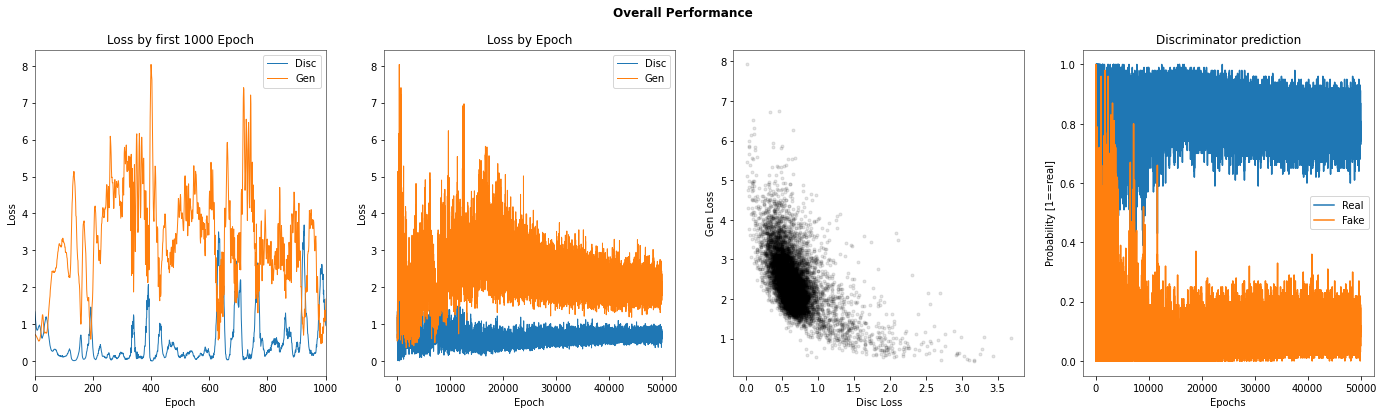

In [ ]:
#%% plot model performance


# plot
fig = plt.figure(figsize=(24, 6))
fig.tight_layout()
fig.suptitle(f'Overall Performance', fontweight='bold')

# setting
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=None, hspace=0.25)


# plot losses
plt.subplot(1, 4, 1)
y_plot_1 = np.array(d_loss).T
y_plot_2 = np.array(g_loss).T
plt.plot(np.arange(1, epochs+1), y_plot_1, linewidth=1)
plt.plot(np.arange(1, epochs+1), y_plot_2, linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss by first 1000 Epoch')
plt.legend(['Disc', 'Gen'])
plt.xlim([0, 1000])


# plot losses
plt.subplot(1, 4, 2)
y_plot_1 = np.array(d_loss).T
y_plot_2 = np.array(g_loss).T
plt.plot(np.arange(1, epochs+1), y_plot_1, linewidth=1)
plt.plot(np.arange(1, epochs+1), y_plot_2, linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss by Epoch')
plt.legend(['Disc', 'Gen'])


# plot losses
plt.subplot(1, 4, 3)
y_plot_1 = np.array(d_loss).T
y_plot_2 = np.array(g_loss).T
plt.plot(y_plot_1[::5], y_plot_2[::5], 'k.', alpha=0.1)
plt.xlabel('Disc Loss')
plt.ylabel('Gen Loss')


# plot discriminator output
plt.subplot(1, 4, 4)
y_plot_1 = np.array(d_pred_train_d).T
y_plot_2 = np.array(d_pred_train_g).T
plt.plot(np.arange(1, epochs+1), y_plot_1)
plt.plot(np.arange(1, epochs+1), y_plot_2)
plt.title('Discriminator prediction')
plt.xlabel('Epochs')
plt.ylabel('Probability [1==real]')
plt.legend(['Real', 'Fake'])

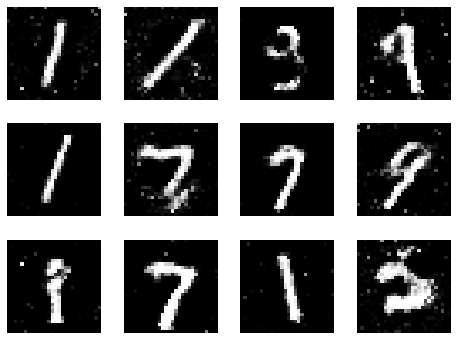

In [ ]:
# generate the images from the generator network

# switch to eval mode
g_net.eval()

# create fake data
fake_data = g_net(torch.randn(12, 64).to(device)).cpu()

# plot
fig, axs = plt.subplots(3, 4, figsize=(8, 6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i, :].detach().view(28, 28), cmap='gray')
  ax.axis('off')